In [1]:
import time
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import os
import numpy as np
from glob import glob
import sklearn
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import pandas as pd

C:\Users\birgi\anaconda3\envs\DL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class PASTISSegmentation(Dataset):
    """
    Here we use a subset of the PASTIS dataset: https://github.com/VSainteuf/pastis-benchmark
    """
    def __init__(
        self,
        image_dir: str,
        annotation_dir: str,
        split:str = "train",
        median_of_days: bool = False,
        Xmean = None,
        Xstd = None,
        binary_labels: bool = False,
        normalize:bool = True,
        transform = None
    ) -> None:
        self.split = split
        self.transform = transform
        images = glob(os.path.join(image_dir, split, 'S2_*.npy'))
        annotations = []
        for im in images:
            name = os.path.splitext(os.path.basename(im))[0].replace("S2_", "")
            annotations.append(os.path.join(annotation_dir, split, f"TARGET_{name}.npy"))

        # Store in the class for future reference
        self.median_of_days = median_of_days
        self.binary_labels = binary_labels
        
        
        # Load data
        self.X = self.read_data(images)
        norm_dims = (0,1,3,4)
        if median_of_days:
            self.X = np.median(self.X, axis=1) #Take median value across 43 days
            norm_dims = (0, 2, 3)
        # Normalize the data if the normalization values are provided
        if Xmean is not None and Xstd is not None:
            self.X = (self.X - Xmean) / Xstd
        
        self.y = self.read_data(annotations)
        self.y = self.y[:,0] # We are only interested in the 20 classes for now
        if binary_labels:
            self.y[self.y>0] = 1 # Convert to binary labels
        self.x_pixel, self.y_pixel = self.pixelwise()
        self.pixelwise_test()
        
    def __len__(self):
        return self.x_pixel.shape[0]
    
    def read_data(self, files):
        """
        Reads and stacks our data
        """
        t = []
        for im in files:
#             print(self.split, np.load(im).shape)
            t.append(np.load(im))
        return np.stack(t, axis=0)
        
    def pixelwise(self):
        """
        This method flattens our images to individual pixels, so we can treat
        each pixel as a sample and train our favirote classifier on it. 
        """
        if self.median_of_days:
            return  np.transpose(self.X, (0, 2, 3, 1)).reshape(-1, 10), self.y.reshape(-1)
        else:
            return  np.transpose(self.X, (0, 3, 4, 1, 2)).reshape(-1, 430), self.y.reshape(-1)
    
    def pixelwise_test(self):
        """
        Short test for the above method.
        """
        N = self.X.shape[0]
        
        pX, py = self.pixelwise()
        if self.median_of_days:
            tX = np.transpose(pX.reshape(N, 128, 128, 10), (0, 3, 1, 2))    
        else:
            tX = np.transpose(pX.reshape(N, 128, 128, 43, 10), (0, 3, 4, 1, 2))
        tY = py.reshape(N, 128, 128)
        assert np.all(tX == self.X) and np.all(tY == self.y)
        print("All test passed!")


    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        if self.binary_labels:
            sample = {'X': torch.FloatTensor(self.x_pixel[idx]), 'y': torch.FloatTensor([self.y_pixel[idx]])} # 'y': torch.FloatTensor([self.y_pixel[idx]])}
        else:
            sample = {'X': torch.FloatTensor(self.x_pixel[idx]), 'y': torch.LongTensor([self.y_pixel[idx]])}
        if self.transform:
            sample = self.transform(sample)

        return sample

In [3]:
base_path = r"C:\Users\birgi\Desktop\Geoinformatics M.Sc\Big DAta\data_week4" # Define it

Xmean = np.array([ 596.57817383, 878.493514, 969.89764811, 1324.39628906, 2368.21767578, 2715.68257243, 2886.70323486, 2977.03915609, 2158.25386556, 1462.10965169])
Xmean = Xmean.reshape((1, 10, 1, 1))
Xstd = np.array([251.33337853, 289.95055489, 438.725014, 398.7289996, 706.53781626, 832.72503267, 898.14189979, 909.04165075, 661.66078257, 529.15340992])
Xstd = Xstd.reshape((1, 10, 1, 1))

p_train = PASTISSegmentation(os.path.join(base_path, "data", "images"),
                             os.path.join(base_path, "data", "annotations"),
                             split="train",
                             median_of_days=True,
                             Xmean=Xmean,
                             Xstd=Xstd,
                             binary_labels=False, 
                             transform = None)

p_val = PASTISSegmentation(os.path.join(base_path, "data", "images"),
                             os.path.join(base_path, "data", "annotations"),
                            split="val",
                            median_of_days=True,
                            Xmean=Xmean,
                            Xstd=Xstd,
                            binary_labels=False, 
                            transform = None)

p_test = PASTISSegmentation(os.path.join(base_path, "data", "images"),
                             os.path.join(base_path, "data", "annotations"),
                            split="test",
                            median_of_days=True,
                            Xmean=Xmean,
                            Xstd=Xstd,
                            binary_labels=False, 
                            transform = None)

All test passed!
All test passed!
All test passed!


In [4]:
# Create a dataloader from the dataset
# Dataloader gives us the possibility to sample a mini-batches instead of only a single sample
BATCH_SIZE = 4096
train_dataloader = DataLoader(p_train, batch_size=BATCH_SIZE,
                        shuffle=True, num_workers=0)

val_dataloader = DataLoader(p_val, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=0)

test_dataloader = DataLoader(p_test, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=0)


In [5]:
for d in test_dataloader:
    print(d['X'].shape, d['y'].shape, )
    print(d['X'].dtype, d['y'].dtype, )
    break

torch.Size([4096, 10]) torch.Size([4096, 1])
torch.float32 torch.int64


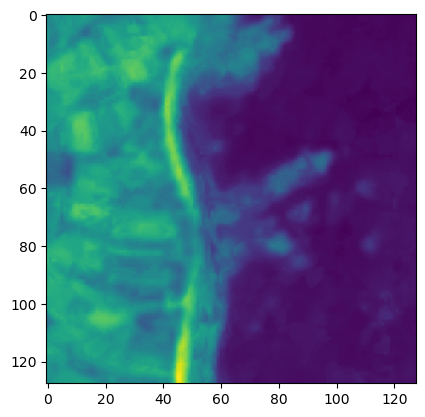

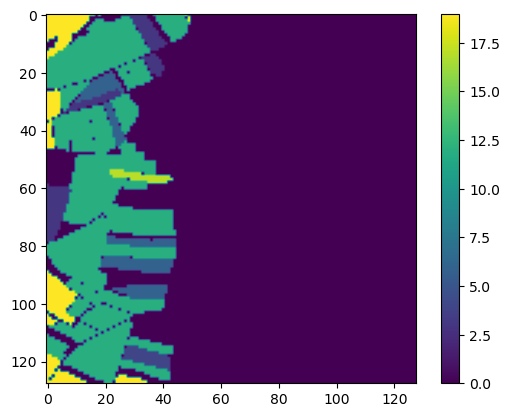

In [6]:
imd = 5
# Show the 3rd band of the third image
plt.imshow(p_train.X[imd, 3])
plt.show()

# Show the labels for third image
plt.imshow(p_train.y[imd])
plt.colorbar()
plt.show()

# Neural Network

In [7]:
# Define our neural network

class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, hidden_activations=None, output_activation=None):
        super(MLP, self).__init__()
        
        # Create a list of fully connected layers
        layers = []
        layer_sizes = [input_size] + hidden_sizes
        
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            if hidden_activations is not None:
                layers.append(hidden_activations)  # Apply activation function on the hidden layers
        
        # Add the output layer
        layers.append(nn.Linear(layer_sizes[-1], output_size))
        if output_activation is not None:
                layers.append(output_activation)  # Apply activation function on the output layer
         
        # Combine all layers into a sequential model
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [8]:
# Define the evaluation loop
def eval_loop(model, val_loader, criterion):
#     print(f"Validating using the val_loader")
    epoch_loss_val = []
    model.eval()
    with torch.no_grad():
        for batch_idx, batch in enumerate(val_loader):
            x, y_true = batch['X'].to(dtype=torch.float32), batch['y']
            y_true = torch.squeeze(y_true)
            y_pred = model(x)

            ### Calcualte loss
            loss = criterion(y_pred, y_true)
            epoch_loss_val.append(loss.item())
    el = torch.mean(torch.FloatTensor(epoch_loss_val))
    model.train()
    return el

# Define the training loop
def train_loop(model, train_loader, val_loader, optimizer, criterion, epochs=50):
    train_loss = []
    val_loss = []
    

    
    for e in range(epochs):
        epoch_loss_train = []
        model.train()
        for batch_idx, batch in enumerate(train_loader):
            x, y_true = batch['X'].to(dtype=torch.float32), batch['y']
            y_true = torch.squeeze(y_true)
            y_pred = model(x)

            ### Calcualte loss
            loss = criterion(y_pred, y_true)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            epoch_loss_train.append(loss.item())

        el = torch.mean(torch.FloatTensor(epoch_loss_train))
        print(f"Train loss for epoch {e}: {el}")
        train_loss.append(el)
        
        vel = eval_loop(model, val_loader, criterion)
        print(f"Validation loss for epoch {e}: {vel}")
        val_loss.append(vel)
        
        
    return model, train_loss, val_loss

In [9]:
# Define our first model
input_size = 10
hidden_sizes = [20, 30, 40]
output_size = 20

model = MLP(input_size, hidden_sizes, output_size, hidden_activations=nn.ReLU(), output_activation=None)

# Define the optimizer, the loss function and 
lr = 0.0001 # The learning rate
optimizer = torch.optim.AdamW(model.parameters(), lr=lr) # Optimizer calculates the gradients and use it to update the model weights. 
criterion = nn.CrossEntropyLoss(reduction='mean')

In [10]:
# Train the model
start_time = time.time()
epochs = 50
model, train_loss, val_loss = train_loop(model, train_dataloader, val_dataloader,  optimizer, criterion, epochs=epochs)
#print(f"Trained for {epochs} epochs in {time.time()-start_time} seconds")


Train loss for epoch 0: 2.9578726291656494
Validation loss for epoch 0: 2.92400860786438
Train loss for epoch 1: 2.8988664150238037
Validation loss for epoch 1: 2.876293420791626
Train loss for epoch 2: 2.8151068687438965
Validation loss for epoch 2: 2.8048620223999023
Train loss for epoch 3: 2.679108142852783
Validation loss for epoch 3: 2.6973280906677246
Train loss for epoch 4: 2.470639228820801
Validation loss for epoch 4: 2.568527936935425
Train loss for epoch 5: 2.226762533187866
Validation loss for epoch 5: 2.465512275695801
Train loss for epoch 6: 2.0313684940338135
Validation loss for epoch 6: 2.4165730476379395
Train loss for epoch 7: 1.9081816673278809
Validation loss for epoch 7: 2.3895561695098877
Train loss for epoch 8: 1.8286902904510498
Validation loss for epoch 8: 2.3623099327087402
Train loss for epoch 9: 1.771471619606018
Validation loss for epoch 9: 2.33834171295166
Train loss for epoch 10: 1.7270820140838623
Validation loss for epoch 10: 2.3143277168273926
Train lo

In [11]:
#create dataframe from train_loss convert and convert it to float
train_loss_1 = pd.DataFrame(train_loss).astype('float') 

#add new column indicating the type of loss (training or validation)
train_loss_1['loss type'] = 'train loss'

#adding epoch aa running number
train_loss_1['epoche'] = list(range(0,50,1))

#repeat for val_loss
val_loss_1 = pd.DataFrame(val_loss).astype('float')
val_loss_1['loss type'] = 'val loss'
val_loss_1['epoche'] = list(range(0,50,1))

#concat dfs and renaume to reflect the losses of model 1
loss_model_1 =pd.concat([train_loss_1, val_loss_1]).rename(columns = {0: 'loss model 1'})
loss_model_1

,loss model 1,loss type,epoche
0,2.957873,train loss,0
1,2.898866,train loss,1
2,2.815107,train loss,2
3,2.679108,train loss,3
4,2.470639,train loss,4
...,...,...,...
45,1.894653,val loss,45
46,1.895145,val loss,46
47,1.884599,val loss,47
48,1.881130,val loss,48


In [12]:
# Define our second model
input_size = 10
hidden_sizes = [2, 2, 2]
output_size = 20

model2 = MLP(input_size, hidden_sizes, output_size, hidden_activations=nn.ReLU(), output_activation=None)
print(model2)

# Define the optimizer, the loss function and 
lr = 0.0001 # The learning rate
optimizer = torch.optim.AdamW(model2.parameters(), lr=lr) # Optimizer calculates the gradients and use it to update the model weights. 
criterion = nn.CrossEntropyLoss(reduction='mean')

MLP(
  (model): Sequential(
    (0): Linear(in_features=10, out_features=2, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2, out_features=2, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2, out_features=2, bias=True)
    (5): ReLU()
    (6): Linear(in_features=2, out_features=20, bias=True)
  )
)


In [13]:
# Train the model2
start_time = time.time()
epochs = 50
model2, train_loss, val_loss = train_loop(model2, train_dataloader, val_dataloader,  optimizer, criterion, epochs=epochs)
print(f"Trained for {epochs} epochs in {time.time()-start_time} seconds")



Train loss for epoch 0: 3.0645883083343506
Validation loss for epoch 0: 2.9270005226135254
Train loss for epoch 1: 3.0579512119293213
Validation loss for epoch 1: 2.922161340713501
Train loss for epoch 2: 3.0513017177581787
Validation loss for epoch 2: 2.9173388481140137
Train loss for epoch 3: 3.044618844985962
Validation loss for epoch 3: 2.912652015686035
Train loss for epoch 4: 3.0378310680389404
Validation loss for epoch 4: 2.9079556465148926
Train loss for epoch 5: 3.0309433937072754
Validation loss for epoch 5: 2.9032394886016846
Train loss for epoch 6: 3.0239672660827637
Validation loss for epoch 6: 2.8985931873321533
Train loss for epoch 7: 3.0168964862823486
Validation loss for epoch 7: 2.893956184387207
Train loss for epoch 8: 3.00972318649292
Validation loss for epoch 8: 2.889368772506714
Train loss for epoch 9: 3.0023677349090576
Validation loss for epoch 9: 2.8848018646240234
Train loss for epoch 10: 2.994738817214966
Validation loss for epoch 10: 2.880197048187256
Train 

In [14]:
# same as before... write output into df and convert to float
train_loss_2 = pd.DataFrame(train_loss).astype('float')

val_loss_2 = pd.DataFrame(val_loss).astype('float')

#concat to get df for model 2
loss_model_2 =pd.concat([train_loss_2, val_loss_2]).rename(columns = {0: 'loss model 2'})

#concat with df for model 1 to get one df for everything
loss_model = pd.concat([loss_model_1, loss_model_2], axis = 1)
loss_model

,loss model 1,loss type,epoche,loss model 2
0,2.957873,train loss,0,3.064588
1,2.898866,train loss,1,3.057951
2,2.815107,train loss,2,3.051302
3,2.679108,train loss,3,3.044619
4,2.470639,train loss,4,3.037831
...,...,...,...,...
45,1.894653,val loss,45,2.688334
46,1.895145,val loss,46,2.684176
47,1.884599,val loss,47,2.679951
48,1.881130,val loss,48,2.675866


(0.0, 4.0)

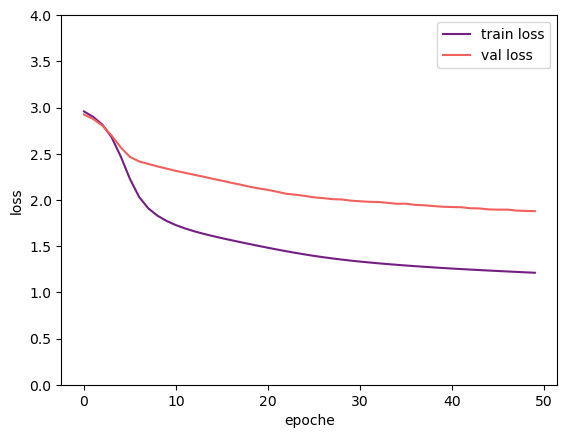

In [15]:
#Plot the training and validation loss as a function of epoch for the two models.

import seaborn as sns
import matplotlib.pyplot as plt

#lineplot, with loss over epoch and type indicated by colour
model_1_plot = sns.lineplot(data = loss_model, x ='epoche', y = 'loss model 1', hue = 'loss type', palette = 'magma').set(xlabel='epoche', ylabel='loss')
plt.legend(title = False)
plt.ylim(0, 4)

(0.0, 4.0)

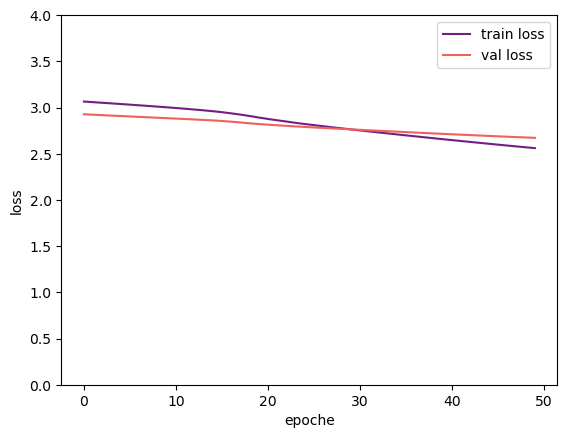

In [16]:
#same for model 2
model_2_plot = sns.lineplot(data = loss_model, x ='epoche', y = 'loss model 2', hue = 'loss type', palette = 'magma').set(xlabel='epoche', ylabel='loss')
plt.legend(title = False)
plt.ylim(0, 4)

In [18]:
#Calculate accuracy, precision, and recall on the test set (or using test_dataloader).

#modify test_dataloader to use the entire dataset (otherwise we cant plot images)
test_dataloader = DataLoader(p_test, batch_size=81920,
                        shuffle=False, num_workers=0)

#use cuda if running on my device, else take the cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# function for accuracy metrics
def calculate_metrics(model, dataloader):
    #set model to evaluation mode
    model.eval()
    
    #define variables for later use
    total_samples = 0
    correct_predictions = 0
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    with torch.no_grad(): #to reduce memory consumption
        for batch_idx, batch in enumerate(test_dataloader):
            
            #define data and target of files in the dataloader
            data, targets = batch['X'].to(dtype=torch.float32), batch['y']
            targets = torch.squeeze(targets)
            
            #predict outputs and set labels to be the maximum probability
            outputs = model(data)
            _, predicted_labels = torch.max(outputs, dim=1)

            
            #define sample size as size of target set
            total_samples += targets.size(0)
            
            #define correct prediction logically as every pixel where the prediction is eqaul to the target
            correct_predictions += (predicted_labels == targets).sum().item()

            #similary define TP, FP and FN
            true_positives += torch.sum(torch.logical_and(predicted_labels == 1, targets == 1))
            false_positives += torch.sum(torch.logical_and(predicted_labels == 1, targets == 0))
            false_negatives += torch.sum(torch.logical_and(predicted_labels == 0, targets == 1))

    # calculate metrics        
    accuracy = correct_predictions / total_samples
    precision = true_positives.float() / (true_positives + false_positives)
    recall = true_positives.float() / (true_positives + false_negatives)

    return accuracy, precision.item(), recall.item()


#apply function
acc1, prec1, recall1 = calculate_metrics(model, test_dataloader)

print('acc model 1:', acc1)
print('prec: model 1:', prec1)
print('recall model 1:', recall1)

acc2, prec2, recall2 = calculate_metrics(model2, test_dataloader)

print('')
print('acc model 2:', acc2)
print('prec: model 2:', prec2)
print('recall model 2:', recall2)

acc model 1: 0.41732177734375
prec: model 1: 0.8014184236526489
recall model 1: 0.44227007031440735

acc model 2: 0.06517333984375
prec: model 2: nan
recall model 2: nan


In [19]:
# classify function extracted form function above 
def classify(model, dataloader):
    model.eval()
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_dataloader):
            data = batch['X'].to(dtype=torch.float32)
            
            outputs = model(data)
            _, predicted_labels = torch.max(outputs, dim=1)
    return predicted_labels

#get classified images
classy_1 = classify(model, test_dataloader)
classy_2 = classify(model2, test_dataloader)



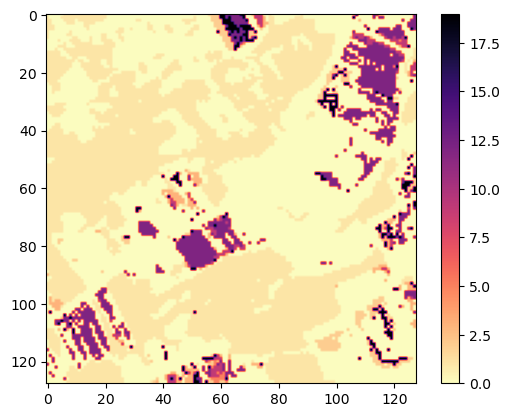

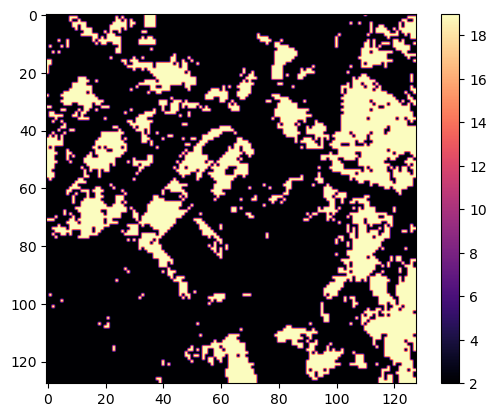

In [24]:
#reshape images to 2d 128, 128 and display
classy_1 = np.array(classy_1)
im_1 = classy_1.copy().reshape(-1, 128, 128)
plt.imshow(im_1[4], cmap='magma_r')
plt.colorbar()
plt.show()

classy_2 = np.array(classy_2)
im_2 = classy_2.copy().reshape(-1, 128, 128)
plt.imshow(im_2[0], cmap='magma')
plt.colorbar()
plt.show()

In [35]:
classy_1.shape

(4096,)